In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as ttf
import numpy as np
import torch
from tcirdataset import TCIRDataSet
from regressionnet import RegressionNet

/home/maria/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Train

We need to set up the necessary variables for training:
batch size, whether we want to use GPU or not, learning rate...

In [3]:
import customtransforms as ctf #for preprocessing
from torch import optim #the optimizer
from torch.nn import MSELoss #Mean Squared Error Loss: the learning criterion
from tqdm import tqdm_notebook as tqdm #for visualization
use_cuda = True #Use GPU
n_epochs=100 #Train for 100 epochs
w_decay=1e-05 #Weight decay
l_rate=5*1e-04 #Learning rate
batch_size=256 
save_freq_epoch = 10 #Save the model every 10 epochs

means=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/mean.npy")) 
stds=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/std.npy")) #Load mean and Standard Deviation
image_t = ttf.Compose([ctf.MatrixRandomRotation(180), #Rotate randomly between 0 and 180 degrees
                               ctf.MatrixCentralCrop(64), #Crop the center to 64x64
                               ttf.ToTensor(), # to 0-1 range
                               ttf.Normalize(mean=means, std=stds) 
                      ])

train_dataset = TCIRDataSet('/mnt/NAS/Trimbot/Data/TCIR/train.h5', transform=image_t) #The dataset!
loader = DataLoader( #The data loader!, same as for classification!
    train_dataset,
    batch_size=batch_size,
    num_workers=8,
    shuffle=True
)
model = RegressionNet() #My model
optimizer = optim.Adam(params=model.parameters(), lr=l_rate, weight_decay=w_decay) #The optimizer
loss = MSELoss() #The criterion
if use_cuda: #GPU optimization
    model=model.cuda()
    loss = loss.cuda()


We are using a tensorboard logger.

In [ ]:
import tensorboard_logger
import datetime
import uuid

ustr = datetime.datetime.now().strftime("%y-%m-%d_%H-%M_") + uuid.uuid4().hex[:3]
logger = tensorboard_logger.Logger("tensorboard/" + "TCIR" + '_' + ustr)



We are ready to train!

In [ ]:
for e in tqdm(range(n_epochs)): #For all epochs
    for i,d in tqdm(enumerate(loader)): #Iterate all over the dataser
        optimizer.zero_grad() #Important: set gradients to 0 in every iteration

        if use_cuda:
            pred = model.forward(d["im"].cuda())#Forward
            err = loss.forward(pred, d["label"].cuda())#Loss
        else:
            pred = model.forward(d["im"])
            err = loss.forward(pred, d["label"])
        err.backward()#Backward
        logger.log_value('train_loss', err, e * len(loader) + i)
        optimizer.step()#Update everything
    if e % save_freq_epoch == 0:#Save the learnt model
        save_path =  "snapshots/" + "TCIR" + '_' + ustr + "_" + str(e) + ".pth"
        torch.save(model.cpu().state_dict(), save_path)
        if use_cuda:
            model = model.cuda()


# Test

Once the model has finished to train, we are ready to test it :)

In [2]:
import customtransforms as ctf
from tqdm import tqdm_notebook as tqdm
from torch.nn import MSELoss
import h5py

use_cuda = True
batch_size=256

means=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/mean.npy"))
stds=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/std.npy"))
image_t = ttf.Compose([ctf.MatrixRandomRotation(180),
                               ctf.MatrixCentralCrop(64),
                               ttf.ToTensor(), # to 0-1 range
                               ttf.Normalize(mean=means, std=stds)
                      ])

test_dataset = TCIRDataSet('/mnt/NAS/Trimbot/Data/TCIR/test.h5', transform=image_t)
loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=8,
    shuffle=False
)

model = RegressionNet()
modelname="TCIR_18-12-18_17-29_377"
loss = MSELoss()
with h5py.File('/mnt/NAS/Trimbot/Data/TCIR/test.h5',"r") as f:
    gt=f["labels"][:]

In [3]:
maxep=100
mses=[]
epochs=np.arange(0,maxep+1,10)
for epoch in epochs:
    model.load_state_dict(torch.load("snapshots/"+modelname+"_"+str(epoch)+".pth")) #Load saved model
    if use_cuda:
        model=model.cuda()
    model = model.eval()#Set model to eval mode
    preds=np.zeros((len(test_dataset),))
    for i,d in tqdm(enumerate(loader)):
        if use_cuda:
            preds[i*batch_size:i*batch_size+batch_size]=model.forward(d["im"].cuda()).cpu().detach().numpy()
        else:
            preds[i*batch_size:i*batch_size+batch_size]=model.forward(d["im"]).detach().numpy()
    np.save("results/preds_"+modelname+"_"+str(epoch)+".npy",preds)#Save predictions
    err = loss.forward(torch.Tensor(preds), torch.Tensor(gt)) #Get and save test error
    mses.append(err)


## Visualize and evaluate
Let us take a look at how the results look like.

### MSE

Text(0,0.5,'MSE')

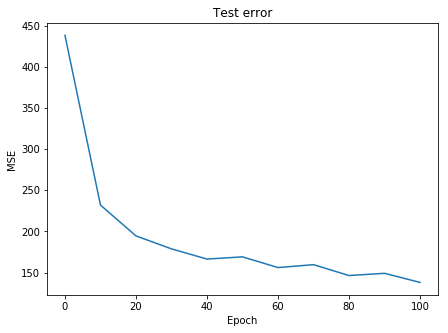

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(epochs,mses)
plt.title("Test error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

### R-measure 
It is a measure that evaluates the quality of the fit of the predictions to the GT. Optimal=1
R^2 = 1 - var(prediction-realisation)/var(realisation)


In [16]:
from sklearn.metrics import r2_score
modelname="TCIR_18-12-18_17-29_377"
gt_var=np.var(gt)
r_squareds=[]
for epoch in epochs:
    preds=np.load("results/preds_"+modelname+"_"+str(epoch)+".npy")#Load predictions
    r_squared=1-np.var(preds-gt)/gt_var
    r_squareds.append(r2_score(gt,preds))
    print(r2_score(gt,preds))
#gt_var

0.5166801728477726
0.7439965158636384
0.7853549419213021
0.8027181527774948
0.8163802729255072
0.8134006670411001
0.8277596481746388
0.8238748220606791
0.8384443045401754
0.8354528070321001
0.8476913877867486


Text(0,0.5,'$R^2$')

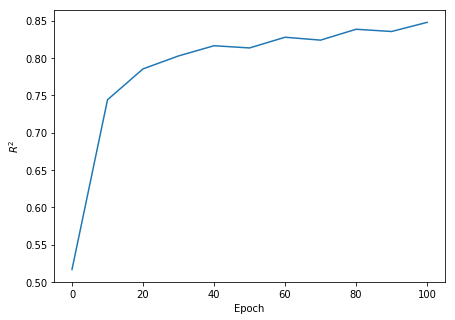

In [17]:
plt.figure(figsize=(7,5))
plt.plot(epochs,r_squareds)
plt.xlabel("Epoch")
plt.ylabel(r'$R^2$')

### Predictions vs GT

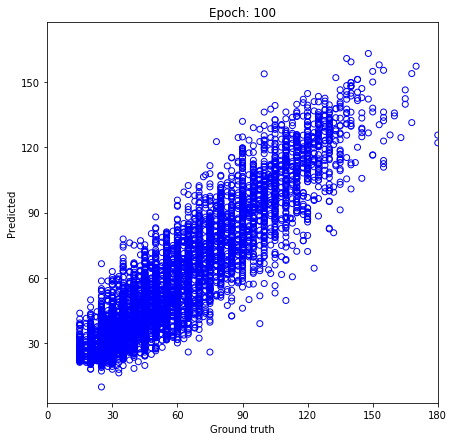

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(gt,preds,marker="o", facecolors='none',  edgecolors='b')
plt.axis("equal")
plt.xlim(0,180)
plt.ylim(0,180)
plt.xticks(np.arange(0,181,30))
plt.xlabel("Ground truth")
plt.yticks(np.arange(0,181,30))
plt.ylabel("Predicted")
plt.title("Epoch: "+str(epoch))
plt.show()

In [13]:
print("MSE", mses[-1])
print("R2", r_squareds[-1])

MSE tensor(138.0545)
R2 0.8478134365638234


[tensor(437.4247)]

In [1]:
import customtransforms as ctf #for preprocessing
means=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/mean.npy")) 
stds=torch.Tensor(np.load("/mnt/NAS/Trimbot/Data/TCIR/std.npy")) #Load mean and Standard Deviation
image_t = ttf.Compose([ctf.MatrixRandomRotation(180), #Rotate randomly between 0 and 180 degrees
                               ctf.MatrixCentralCrop(64), #Crop the center to 64x64
                               ttf.ToTensor(), # to 0-1 range
                               ttf.Normalize(mean=means, std=stds) 
                      ])
train_dataset = TCIRDataSet('/mnt/NAS/Trimbot/Data/TCIR/train.h5', transform=image_t)
test_dataset = TCIRDataSet('/mnt/NAS/Trimbot/Data/TCIR/test.h5', transform=image_t)

NameError: name 'torch' is not defined

NameError: name 'torch' is not defined

In [10]:
len(train_dataset)+len(test_dataset)

47381

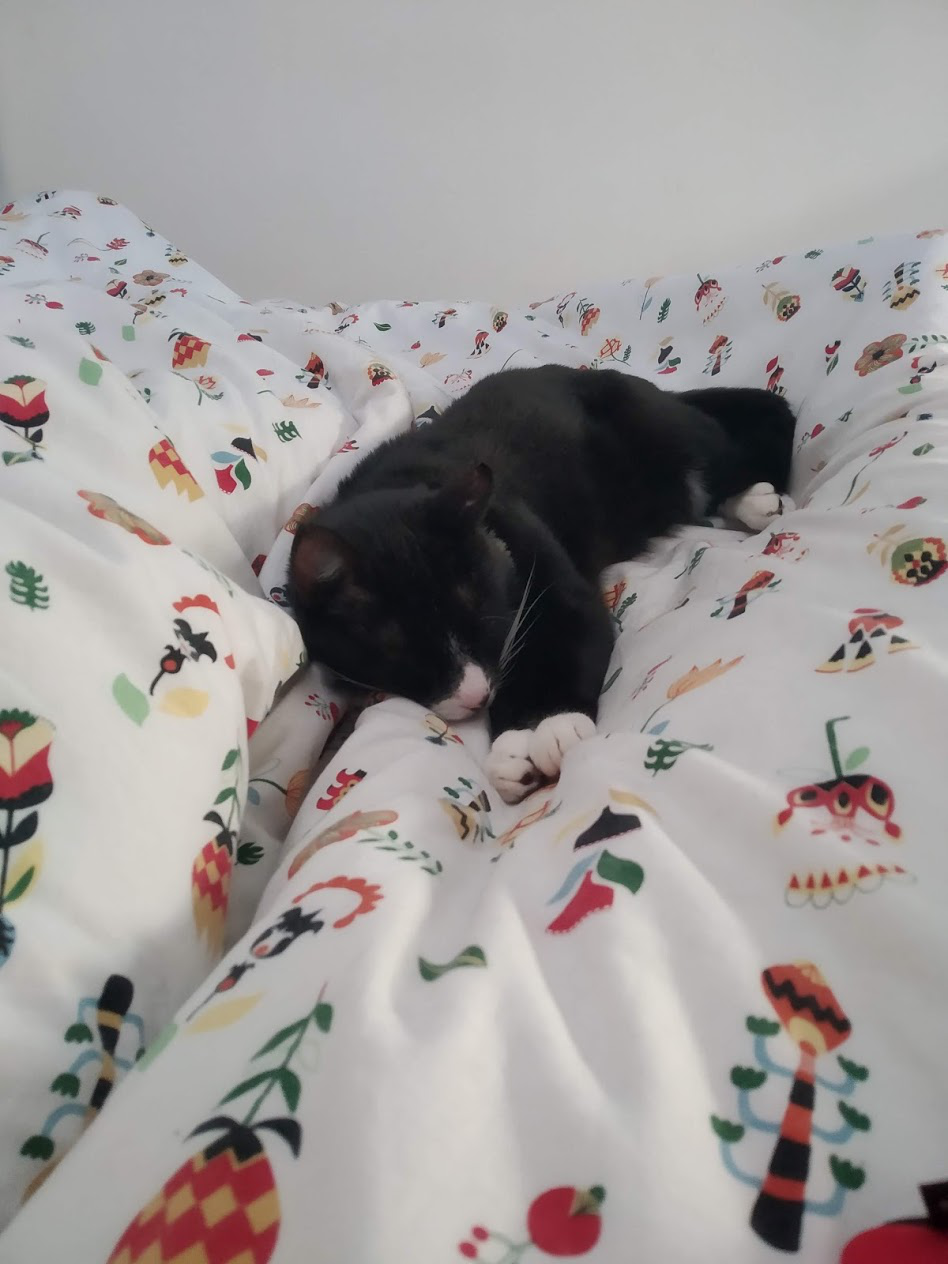

In [7]:
image = Image.open("bilbo.jpg").convert('RGB')
image

In [8]:
bbtensor=val.transform(image)

In [10]:
Softmax()(model.forward(bbtensor.unsqueeze(0).cuda()))

/home/maria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.3114, 0.6886]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


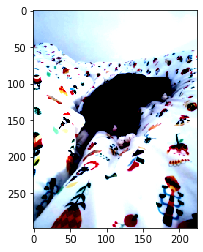

In [13]:
import matplotlib.pyplot as plt
plt.imshow(bbtensor.cpu().detach().numpy().transpose(1,2,0))

In [28]:
from torch.utils.data import Dataset
from torchvision import transforms as ttf
from torchvision import models
import numpy as np
import os
from PIL import Image



class DogsVdCatsDataSet(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            datafile (string): Path to the dataset file (.h5)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root=root
        self.transform = transform
        self.idx=os.listdir(self.root)


    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        img_name=self.root+self.idx[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image=self.transform(image)
        label=int(self.idx[idx].startswith("dog"))
        return {"im":image, "label":label}


data=DogsVdCatsDataSet("/mnt/NAS/Trimbot/Data/catvsdogs/train/")


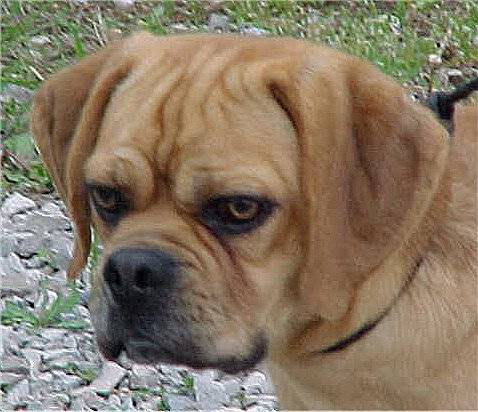

In [42]:
data[3139]["im"]